In [274]:
import sys
import sql
import pandas as pd
from functools import reduce
from tabulate import tabulate
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
norepo = 'no repository listed'
manualcheckup = 'manual checkup needed'
notgit = 'not git'

In [275]:
q = '''select *
from fix_commits fc
join fixing_releases fr on fc.advisory_id = fr.advisory_id
where commit_date is not null
and version!=%s;'''
df = pd.DataFrame(sql.execute(q,(manualcheckup)))
df['advisory_id'].nunique()

2497

In [276]:
#not present in Maven central repository
q='''select *
from fix_commits fc
join fixing_releases fr on fc.advisory_id = fr.advisory_id
join package p on fc.package_id = p.id
where commit_date is not null
and version!=%s
and fc.advisory_id not in
(select advisory_id
from fixing_releases fr
join advisory a on fr.advisory_id = a.id
join release_info ri on fr.version = ri.version and ri.package_id=a.package_id);'''
df = pd.DataFrame(sql.execute(q,(manualcheckup)))
df['package_id'].nunique(), df['advisory_id'].nunique()

(75, 145)

In [277]:
q='''select *
from fix_commits fc
join fixing_releases fr on fc.advisory_id = fr.advisory_id
join package p on fc.package_id = p.id
join release_info ri on p.id = ri.package_id and ri.version=fr.version
where commit_date is not null
and fr.version!='manual checkup needed'
and ri.publish_date is null;'''
df = pd.DataFrame(sql.execute(q))
df['ri.id'].nunique(), df['package_id'].nunique(), df['advisory_id'].nunique()

(357, 272, 341)

In [278]:
q = '''select advisory_id, count(distinct commit_sha)
from fix_commits
where commit_date is not null
group by advisory_id
having count(distinct commit_sha) > 1'''
df = pd.DataFrame(sql.execute(q))
len(df)

806

In [279]:
q='''select id as advisory_id,
       case
        when id in (select advisory_id from advisoryCVE) then 'cve'
        else 'noncve'
end as ifcve
from advisory;'''
ifcve = pd.DataFrame(sql.execute(q))

In [280]:
q = '''select * from package_usage pu
join package p on pu.package_id = p.id'''
usage = pd.DataFrame(sql.execute(q))

In [281]:
q = '''select advisory_id, package_id, ecosystem, type, severity, disclose_date, publish_date,
        earliest_fix_commit_date, latest_fix_commit_date, release_date, version, concat('package', package_id, 'version', version) as fixing_release,
       concat(advisory_id, package_id, version) as total_release
        from
        (select advisory_id, min(commit_date) as earliest_fix_commit_date, max(commit_date) as latest_fix_commit_date
        from fix_commits fc
        join package p on fc.package_id = p.id
        where commit_date is not null
        group by advisory_id) as fcd
        join
        (select a.*, p.ecosystem, ri.version, ri.publish_date as release_date
        from advisory a
        join package p on a.package_id = p.id
        join fixing_releases fr on a.id = fr.advisory_id
        join release_info ri on p.id = ri.package_id and ri.version=fr.version
        where type != 'Malicious Package'
        and fr.version!= 'manual checkup needed'
            and ri.publish_date is not null) as frd
        on fcd.advisory_id=frd.id;
'''
df = pd.DataFrame(sql.execute(q))
df

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,earliest_fix_commit_date,latest_fix_commit_date,release_date,version,fixing_release,total_release
0,SNYK-PYTHON-SALT-174927,1,pip,Arbitrary Code Execution,H,2013-05-11,2019-06-06,2013-09-19 18:27:38,2013-09-19 20:28:04,2013-10-17 18:17:40,0.17.1,package1version0.17.1,SNYK-PYTHON-SALT-17492710.17.1
1,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:33:50,2016.11.8,package1version2016.11.8,SNYK-PYTHON-SALT-4068712016.11.8
2,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:30:36,2016.3.8,package1version2016.3.8,SNYK-PYTHON-SALT-4068712016.3.8
3,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:39:22,2017.7.2,package1version2017.7.2,SNYK-PYTHON-SALT-4068712017.7.2
4,SNYK-PYTHON-SALT-40688,1,pip,Directory Traversal,H,2017-08-23,2017-11-05,2017-08-31 17:06:33,2017-10-03 22:19:25,2017-10-09 16:33:50,2016.11.8,package1version2016.11.8,SNYK-PYTHON-SALT-4068812016.11.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,SNYK-JS-APOLLOGATEWAY-174915,1852,npm,Prototype Pollution,H,2019-06-04,2019-06-05,2019-06-04 23:23:04,2019-06-04 23:23:04,2019-06-04 23:25:34,0.6.2,package1852version0.6.2,SNYK-JS-APOLLOGATEWAY-17491518520.6.2
2785,SNYK-PHP-LIGHTSAMLLIGHTSAML-72139,2335,Composer,Access Restriction Bypass,H,2018-04-18,2018-04-26,2018-03-05 16:26:57,2018-03-05 16:26:57,2018-03-05 16:29:08,1.3.5,package2335version1.3.5,SNYK-PHP-LIGHTSAMLLIGHTSAML-7213923351.3.5
2786,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:10:02,8.7.23,package272version8.7.23,SNYK-PHP-TYPO3CMS-735942728.7.23
2787,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:12:04,9.5.4,package272version9.5.4,SNYK-PHP-TYPO3CMS-735942729.5.4


In [282]:
def get_fix_commit_date(row):
    if row['earliest_fix_commit_date'] == row['latest_fix_commit_date']:
        return row['earliest_fix_commit_date']
    else:
        if row['latest_fix_commit_date'] <= row['release_date']:
            return row['latest_fix_commit_date']
        else:
            return row['earliest_fix_commit_date']

df['fix_commit_date'] = df.apply(get_fix_commit_date, axis=1)
df

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,earliest_fix_commit_date,latest_fix_commit_date,release_date,version,fixing_release,total_release,fix_commit_date
0,SNYK-PYTHON-SALT-174927,1,pip,Arbitrary Code Execution,H,2013-05-11,2019-06-06,2013-09-19 18:27:38,2013-09-19 20:28:04,2013-10-17 18:17:40,0.17.1,package1version0.17.1,SNYK-PYTHON-SALT-17492710.17.1,2013-09-19 20:28:04
1,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:33:50,2016.11.8,package1version2016.11.8,SNYK-PYTHON-SALT-4068712016.11.8,2017-10-03 22:17:19
2,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:30:36,2016.3.8,package1version2016.3.8,SNYK-PYTHON-SALT-4068712016.3.8,2017-10-03 22:17:19
3,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:39:22,2017.7.2,package1version2017.7.2,SNYK-PYTHON-SALT-4068712017.7.2,2017-10-03 22:17:19
4,SNYK-PYTHON-SALT-40688,1,pip,Directory Traversal,H,2017-08-23,2017-11-05,2017-08-31 17:06:33,2017-10-03 22:19:25,2017-10-09 16:33:50,2016.11.8,package1version2016.11.8,SNYK-PYTHON-SALT-4068812016.11.8,2017-10-03 22:19:25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,SNYK-JS-APOLLOGATEWAY-174915,1852,npm,Prototype Pollution,H,2019-06-04,2019-06-05,2019-06-04 23:23:04,2019-06-04 23:23:04,2019-06-04 23:25:34,0.6.2,package1852version0.6.2,SNYK-JS-APOLLOGATEWAY-17491518520.6.2,2019-06-04 23:23:04
2785,SNYK-PHP-LIGHTSAMLLIGHTSAML-72139,2335,Composer,Access Restriction Bypass,H,2018-04-18,2018-04-26,2018-03-05 16:26:57,2018-03-05 16:26:57,2018-03-05 16:29:08,1.3.5,package2335version1.3.5,SNYK-PHP-LIGHTSAMLLIGHTSAML-7213923351.3.5,2018-03-05 16:26:57
2786,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:10:02,8.7.23,package272version8.7.23,SNYK-PHP-TYPO3CMS-735942728.7.23,2019-01-22 08:42:56
2787,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:12:04,9.5.4,package272version9.5.4,SNYK-PHP-TYPO3CMS-735942729.5.4,2019-01-22 08:42:56


In [283]:
df['fix_to_release_delay'] = (df['release_date'] - df['fix_commit_date']).dt.total_seconds()
df['fix_to_release_delay'] = round ( df['fix_to_release_delay'] / (3600 * 24))
df['disclose_to_fix_delay'] = (df['fix_commit_date'].dt.date - df['disclose_date']).dt.days
df['release_to_publish_delay'] = (df['publish_date'] - df['release_date'].dt.date).dt.days
df['fix_to_publish_delay'] = (df['publish_date'] - df['fix_commit_date'].dt.date).dt.days
df

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,earliest_fix_commit_date,latest_fix_commit_date,release_date,version,fixing_release,total_release,fix_commit_date,fix_to_release_delay,disclose_to_fix_delay,release_to_publish_delay,fix_to_publish_delay
0,SNYK-PYTHON-SALT-174927,1,pip,Arbitrary Code Execution,H,2013-05-11,2019-06-06,2013-09-19 18:27:38,2013-09-19 20:28:04,2013-10-17 18:17:40,0.17.1,package1version0.17.1,SNYK-PYTHON-SALT-17492710.17.1,2013-09-19 20:28:04,28.0,131,2058,2086
1,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:33:50,2016.11.8,package1version2016.11.8,SNYK-PYTHON-SALT-4068712016.11.8,2017-10-03 22:17:19,6.0,40,27,33
2,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:30:36,2016.3.8,package1version2016.3.8,SNYK-PYTHON-SALT-4068712016.3.8,2017-10-03 22:17:19,6.0,40,27,33
3,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:39:22,2017.7.2,package1version2017.7.2,SNYK-PYTHON-SALT-4068712017.7.2,2017-10-03 22:17:19,6.0,40,27,33
4,SNYK-PYTHON-SALT-40688,1,pip,Directory Traversal,H,2017-08-23,2017-11-05,2017-08-31 17:06:33,2017-10-03 22:19:25,2017-10-09 16:33:50,2016.11.8,package1version2016.11.8,SNYK-PYTHON-SALT-4068812016.11.8,2017-10-03 22:19:25,6.0,41,27,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,SNYK-JS-APOLLOGATEWAY-174915,1852,npm,Prototype Pollution,H,2019-06-04,2019-06-05,2019-06-04 23:23:04,2019-06-04 23:23:04,2019-06-04 23:25:34,0.6.2,package1852version0.6.2,SNYK-JS-APOLLOGATEWAY-17491518520.6.2,2019-06-04 23:23:04,0.0,0,1,1
2785,SNYK-PHP-LIGHTSAMLLIGHTSAML-72139,2335,Composer,Access Restriction Bypass,H,2018-04-18,2018-04-26,2018-03-05 16:26:57,2018-03-05 16:26:57,2018-03-05 16:29:08,1.3.5,package2335version1.3.5,SNYK-PHP-LIGHTSAMLLIGHTSAML-7213923351.3.5,2018-03-05 16:26:57,0.0,-44,52,52
2786,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:10:02,8.7.23,package272version8.7.23,SNYK-PHP-TYPO3CMS-735942728.7.23,2019-01-22 08:42:56,0.0,0,0,0
2787,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:12:04,9.5.4,package272version9.5.4,SNYK-PHP-TYPO3CMS-735942729.5.4,2019-01-22 08:42:56,0.0,0,0,0


In [284]:
df['advisory_id'].nunique(), df['fixing_release'].nunique(),  df['total_release'].nunique()

(2068, 2355, 2789)

In [285]:
total = len(df)
d2f = df[df['disclose_to_fix_delay'] > 0]
before = len(d2f)
d2f['disclose_to_fix_delay'].describe(), before/total


(count     781.000000
 mean       79.177977
 std       193.344665
 min         1.000000
 25%         2.000000
 50%         8.000000
 75%        42.000000
 max      1849.000000
 Name: disclose_to_fix_delay, dtype: float64,
 0.28002868411617066)

In [286]:
df['release_to_publish_delay'].describe()

count    2789.000000
mean      178.426318
std       464.064366
min     -1756.000000
25%         1.000000
50%        11.000000
75%       132.000000
max      4918.000000
Name: release_to_publish_delay, dtype: float64

In [287]:
wrong = df[df['fix_to_release_delay'] < 0]
wrong = wrong.sample(frac=1).reset_index(drop=True)
wrong.to_csv('delaylessthanzero.csv', index=False)
len(wrong)

149

In [288]:
temp = df[df['fix_to_publish_delay']<0]
temp = pd.merge(temp, ifcve)
temp

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,earliest_fix_commit_date,latest_fix_commit_date,release_date,version,fixing_release,total_release,fix_commit_date,fix_to_release_delay,disclose_to_fix_delay,release_to_publish_delay,fix_to_publish_delay,ifcve
0,SNYK-PYTHON-AIOHTTP-40582,6,pip,Directory Traversal,M,2015-05-28,2015-05-28,2015-05-28 21:39:05,2015-05-30 19:03:25,2015-05-30 19:28:53,0.16.3,package6version0.16.3,SNYK-PYTHON-AIOHTTP-4058260.16.3,2015-05-30 19:03:25,0.0,2,-2,-2,noncve
1,SNYK-PYTHON-CHANNELS-73623,39,pip,Denial of Service (DoS),M,2018-10-16,2018-10-16,2019-01-25 22:18:51,2019-01-25 22:18:51,2019-02-01 01:36:15,2.1.7,package39version2.1.7,SNYK-PYTHON-CHANNELS-73623392.1.7,2019-01-25 22:18:51,6.0,101,-108,-101,noncve
2,SNYK-PYTHON-ANSIBLE-559099,83,pip,Information Exposure,M,2020-02-28,2020-03-02,2020-04-06 16:51:09,2020-04-09 18:42:25,2020-04-17 00:26:26,2.7.17,package83version2.7.17,SNYK-PYTHON-ANSIBLE-559099832.7.17,2020-04-09 18:42:25,7.0,41,-46,-38,cve
3,SNYK-PYTHON-ANSIBLE-559099,83,pip,Information Exposure,M,2020-02-28,2020-03-02,2020-04-06 16:51:09,2020-04-09 18:42:25,2020-04-17 00:53:48,2.8.11,package83version2.8.11,SNYK-PYTHON-ANSIBLE-559099832.8.11,2020-04-09 18:42:25,7.0,41,-46,-38,cve
4,SNYK-PYTHON-ANSIBLE-559099,83,pip,Information Exposure,M,2020-02-28,2020-03-02,2020-04-06 16:51:09,2020-04-09 18:42:25,2020-04-17 01:31:46,2.9.7,package83version2.9.7,SNYK-PYTHON-ANSIBLE-559099832.9.7,2020-04-09 18:42:25,7.0,41,-46,-38,cve
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,SNYK-PYTHON-PYTHONLIBNMAP-460758,3600,pip,XML External Entity (XXE) Injection,H,2019-07-15,2019-07-15,2020-11-23 20:30:20,2020-11-25 08:22:18,2020-12-16 22:39:52,0.7.2,package3600version0.7.2,SNYK-PYTHON-PYTHONLIBNMAP-46075836000.7.2,2020-11-25 08:22:18,22.0,499,-520,-499,cve
215,SNYK-JAVA-ORGCRYPTACULAR-543303,3683,Maven,Denial of Service (DoS),H,2020-01-26,2020-01-27,2020-01-23 20:28:27,2020-02-19 14:17:27,2020-02-27 16:53:00,1.1.4,package3683version1.1.4,SNYK-JAVA-ORGCRYPTACULAR-54330336831.1.4,2020-02-19 14:17:27,8.0,24,-31,-23,cve
216,SNYK-GOLANG-GITHUBCOMARTDAREKGOUNZIP-559505,3715,Go,Arbitrary File Write via Archive Extraction (Z...,M,2020-03-05,2020-03-05,2020-03-07 21:51:43,2020-03-07 21:51:43,2020-03-08 07:21:21,1.0.0,package3715version1.0.0,SNYK-GOLANG-GITHUBCOMARTDAREKGOUNZIP-559505371...,2020-03-07 21:51:43,0.0,2,-3,-2,noncve
217,SNYK-JS-FORMIOJS-560149,3866,npm,Cross-site Scripting (XSS),M,2020-07-07,2020-07-07,2020-05-09 15:50:04,2020-10-28 17:40:32,2020-10-28 18:39:44,4.12.1-rc.19,package3866version4.12.1-rc.19,SNYK-JS-FORMIOJS-56014938664.12.1-rc.19,2020-10-28 17:40:32,0.0,113,-113,-113,noncve


In [289]:
q = '''select advisory_id, cwe, package_id, ecosystem, type, severity, disclose_date, publish_date,
earliest_fix_commit_date, latest_fix_commit_date, release_date, version, concat('package', package_id, 'version', version) as fixing_release,
concat(advisory_id, package_id, version) as total_release
from
(select advisory_id, min(commit_date) as earliest_fix_commit_date, max(commit_date) as latest_fix_commit_date
from fix_commits fc
join package p on fc.package_id = p.id
where commit_date is not null
group by advisory_id) as fcd
join
(select a.*, ac.cwe, p.ecosystem, ri.version, ri.publish_date as release_date
from advisory a
    join advisoryCWE aC on a.id = aC.advisory_id
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join release_info ri on p.id = ri.package_id and ri.version=fr.version
where type != 'Malicious Package'
and fr.version!= 'manual checkup needed'
    and ri.publish_date is not null) as frd
on fcd.advisory_id=frd.id;'''
cwe = pd.DataFrame(sql.execute(q))
total_cwes = cwe['cwe'].nunique()
cwe = cwe.groupby('ecosystem')[['cwe']].nunique()
cwe

,cwe
ecosystem,
Composer,40
Go,46
Maven,83
NuGet,10
RubyGems,41
npm,72
pip,68


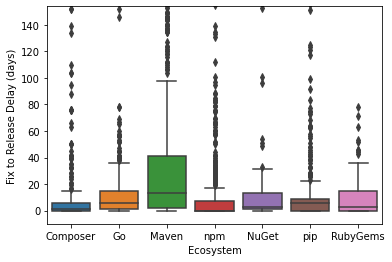

In [290]:
df= df[df['fix_to_release_delay'] >= 0]
ax = sns.boxplot(y='fix_to_release_delay', x='ecosystem', data = df, order =['Composer','Go','Maven','npm','NuGet','pip','RubyGems'])
ax.set(ylim =(-10,154), xlabel='Ecosystem', ylabel = 'Fix to Release Delay (days)')
plt.savefig('fix_to_release_delay.png',bbox_inches='tight')

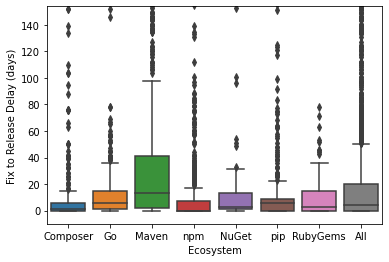

In [291]:
temp = df.copy()
temp['ecosystem'] = "All"
temp = pd.concat([temp, df], axis=0)
ax = sns.boxplot(y='fix_to_release_delay', x='ecosystem', data = temp, order =['Composer','Go','Maven','npm','NuGet','pip','RubyGems', 'All'])
ax.set(ylim =(-10,154), xlabel='Ecosystem', ylabel = 'Fix to Release Delay (days)')
plt.savefig('fix_to_release_delay.png',bbox_inches='tight')

In [292]:
df

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,earliest_fix_commit_date,latest_fix_commit_date,release_date,version,fixing_release,total_release,fix_commit_date,fix_to_release_delay,disclose_to_fix_delay,release_to_publish_delay,fix_to_publish_delay
0,SNYK-PYTHON-SALT-174927,1,pip,Arbitrary Code Execution,H,2013-05-11,2019-06-06,2013-09-19 18:27:38,2013-09-19 20:28:04,2013-10-17 18:17:40,0.17.1,package1version0.17.1,SNYK-PYTHON-SALT-17492710.17.1,2013-09-19 20:28:04,28.0,131,2058,2086
1,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:33:50,2016.11.8,package1version2016.11.8,SNYK-PYTHON-SALT-4068712016.11.8,2017-10-03 22:17:19,6.0,40,27,33
2,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:30:36,2016.3.8,package1version2016.3.8,SNYK-PYTHON-SALT-4068712016.3.8,2017-10-03 22:17:19,6.0,40,27,33
3,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:39:22,2017.7.2,package1version2017.7.2,SNYK-PYTHON-SALT-4068712017.7.2,2017-10-03 22:17:19,6.0,40,27,33
4,SNYK-PYTHON-SALT-40688,1,pip,Directory Traversal,H,2017-08-23,2017-11-05,2017-08-31 17:06:33,2017-10-03 22:19:25,2017-10-09 16:33:50,2016.11.8,package1version2016.11.8,SNYK-PYTHON-SALT-4068812016.11.8,2017-10-03 22:19:25,6.0,41,27,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,SNYK-JS-APOLLOGATEWAY-174915,1852,npm,Prototype Pollution,H,2019-06-04,2019-06-05,2019-06-04 23:23:04,2019-06-04 23:23:04,2019-06-04 23:25:34,0.6.2,package1852version0.6.2,SNYK-JS-APOLLOGATEWAY-17491518520.6.2,2019-06-04 23:23:04,0.0,0,1,1
2785,SNYK-PHP-LIGHTSAMLLIGHTSAML-72139,2335,Composer,Access Restriction Bypass,H,2018-04-18,2018-04-26,2018-03-05 16:26:57,2018-03-05 16:26:57,2018-03-05 16:29:08,1.3.5,package2335version1.3.5,SNYK-PHP-LIGHTSAMLLIGHTSAML-7213923351.3.5,2018-03-05 16:26:57,0.0,-44,52,52
2786,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:10:02,8.7.23,package272version8.7.23,SNYK-PHP-TYPO3CMS-735942728.7.23,2019-01-22 08:42:56,0.0,0,0,0
2787,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:12:04,9.5.4,package272version9.5.4,SNYK-PHP-TYPO3CMS-735942729.5.4,2019-01-22 08:42:56,0.0,0,0,0


In [296]:
usage = pd.merge(df, usage, on=['package_id', 'ecosystem'])


0.009425071746242889

In [303]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr
ecosystems = ['Composer','Go','Maven','npm','NuGet','pip','RubyGems']
l=[]
newl = []
for ecosystem in ecosystems:
    temp = usage[usage['ecosystem'] ==  ecosystem ]
    a = spearmanr(temp['fix_to_release_delay'], temp['dependent'])
    b = spearmanr(temp['fix_to_release_delay'], temp['dependent_repos'])
    l.append([ecosystem, a ,b])
    newl.append([ecosystem, round(a[0],2), round(b[0],2)])

l.append(['All', spearmanr(usage['fix_to_release_delay'], usage['dependent']), spearmanr(usage['fix_to_release_delay'], usage['dependent_repos'])])
newll.append(['All', spearmanr(usage['fix_to_release_delay'], usage['dependent'])[0], spearmanr(usage['fix_to_release_delay'], usage['dependent_repos'])[0]])
l

[['Composer',
  SpearmanrResult(correlation=0.103912137130737, pvalue=0.0),
  SpearmanrResult(correlation=0.10288778623004462, pvalue=0.0)],
 ['Go',
  SpearmanrResult(correlation=-0.07549862362491812, pvalue=0.021162638773364717),
  SpearmanrResult(correlation=-0.0693435328052505, pvalue=0.03428756968056699)],
 ['Maven',
  SpearmanrResult(correlation=-0.10310327070585464, pvalue=0.0),
  SpearmanrResult(correlation=-0.10959620407332638, pvalue=0.0)],
 ['npm',
  SpearmanrResult(correlation=0.10972326080448333, pvalue=0.0),
  SpearmanrResult(correlation=0.08499266932196559, pvalue=0.0)],
 ['NuGet',
  SpearmanrResult(correlation=0.05570426785839141, pvalue=2.1097200267555467e-19),
  SpearmanrResult(correlation=0.054298285685101824, pvalue=1.6387384811479745e-18)],
 ['pip',
  SpearmanrResult(correlation=-0.31312689401098975, pvalue=0.0),
  SpearmanrResult(correlation=-0.3005453132723682, pvalue=0.0)],
 ['RubyGems',
  SpearmanrResult(correlation=-0.1705719023800262, pvalue=5.488669669098709e

In [305]:
newl =  pd.DataFrame(newl, columns={'Ecosytem', 'Dependent Packages', 'Dependent Repositories'})
newl

,Dependent Repositories,Dependent Packages,Ecosytem
0,Composer,0.10,0.10
1,Go,-0.08,-0.07
2,Maven,-0.10,-0.11
3,npm,0.11,0.08
4,NuGet,0.06,0.05
5,pip,-0.31,-0.30
6,RubyGems,-0.17,-0.15


In [183]:
len(df[df['fix_to_release_delay']>= 500])
df['fix_to_release_delay'].describe()

count    2640.000000
mean       30.954924
std       115.271483
min         0.000000
25%         0.000000
50%         4.000000
75%        20.000000
max      2363.000000
Name: fix_to_release_delay, dtype: float64

In [184]:
npm =df[df['ecosystem']=='npm']
len(npm), len(npm[npm['fix_to_release_delay']==0])

(640, 322)

In [185]:
maven = df[df['ecosystem']=='Maven']
maven['fix_to_release_delay'].describe(), len(maven[maven['fix_to_release_delay']==0])

(count     807.000000
 mean       51.630731
 std       162.032630
 min         0.000000
 25%         2.000000
 50%        13.000000
 75%        41.000000
 max      2363.000000
 Name: fix_to_release_delay, dtype: float64,
 121)

In [186]:
pbf = df[df['fix_to_publish_delay'] < 0]
pbf['release_to_publish_delay'].describe()

count     206.000000
mean     -121.334951
std       209.524687
min     -1196.000000
25%      -149.250000
50%       -32.000000
75%        -9.000000
max        -1.000000
Name: release_to_publish_delay, dtype: float64

In [187]:
pbr = df[(df['release_to_publish_delay'] < 0) & (df['fix_to_publish_delay'] >= 0)]
pbr['release_to_publish_delay'].describe()

count     271.000000
mean      -76.276753
std       189.424628
min     -1756.000000
25%       -65.500000
50%       -17.000000
75%        -6.000000
max        -1.000000
Name: release_to_publish_delay, dtype: float64

In [188]:
pub_before_release = df.groupby(['ecosystem','advisory_id'])[['release_to_publish_delay']].max()
pub_before_release = pub_before_release.reset_index()
pub_before_release = pub_before_release[pub_before_release['release_to_publish_delay'] < 0]
pub_before_release = len(pub_before_release)

pub_before_release = str(pub_before_release) + ' (' +  str(round(pub_before_release/df['advisory_id'].nunique()*100,1)) +'%)'
pub_before_fix = df.groupby(['ecosystem','advisory_id'])[['fix_to_publish_delay']].max()
pub_before_fix = pub_before_fix.reset_index()
pub_before_fix = pub_before_fix[pub_before_fix['fix_to_publish_delay'] < 0]
pub_before_fix = len(pub_before_fix)
pub_before_fix = str(pub_before_fix) + ' (' + str(round(pub_before_fix/df['advisory_id'].nunique()*100,1)) +'%)'
t = ['Total', df['advisory_id'].nunique(), df['package_id'].nunique(), df['fixing_release'].nunique(), 
total_cwes,
df['fix_to_release_delay'].median(),
df['total_release'].nunique(), pub_before_fix, pub_before_release ]
t[3] = str(t[3]) + ' (' + str(t[6]) +')'
del t[6]
t

['Total', 2001, 1342, '2240 (2640)', 143, 4.0, '165 (8.2%)', '388 (19.4%)']

In [189]:
gb = df.groupby('ecosystem')
eco_dfs = [(x,gb.get_group(x)) for x in gb.groups]
adv = df.groupby('ecosystem')[['advisory_id']].nunique()
pkg = df.groupby('ecosystem')[['package_id']].nunique()
rel = df.groupby('ecosystem')['fixing_release'].nunique()
total_rel = df.groupby('ecosystem')['total_release'].nunique()
fixrel = df.groupby('ecosystem')[['fix_to_release_delay']].median()

In [190]:
pub_before_release = df.groupby(['ecosystem','advisory_id'])[['release_to_publish_delay']].max()
pub_before_release = pub_before_release.reset_index()
pub_before_release = pub_before_release[pub_before_release['release_to_publish_delay'] < 0]
pub_before_release = pub_before_release.groupby('ecosystem')[['advisory_id']].nunique()
pub_before_release = pub_before_release.rename(columns={'advisory_id':'pub_before_release'})
pub_before_release

,pub_before_release
ecosystem,
Composer,20
Go,47
Maven,131
NuGet,5
RubyGems,10
npm,102
pip,73


In [191]:
pub_before_fix = df.groupby(['ecosystem','advisory_id'])[['fix_to_publish_delay']].max()
pub_before_fix = pub_before_fix.reset_index()
pub_before_fix = pub_before_fix[pub_before_fix['fix_to_publish_delay'] < 0]
pub_before_fix = pub_before_fix.groupby('ecosystem')[['advisory_id']].nunique()
pub_before_fix = pub_before_fix.rename(columns={'advisory_id':'pub_before_fix'})
pub_before_fix

,pub_before_fix
ecosystem,
Composer,10
Go,21
Maven,27
NuGet,4
RubyGems,5
npm,62
pip,36


In [192]:
final =reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[adv, pkg, rel,cwe, fixrel, pub_before_fix,pub_before_release, total_rel])
final = final.reset_index()
final['fixing_release'] = final['fixing_release'].map(str) +  ' (' + final['total_release'].map(str) +')'
final

,ecosystem,advisory_id,package_id,fixing_release,cwe,fix_to_release_delay,pub_before_fix,pub_before_release,total_release
0,Composer,183,93,204 (295),40,1.0,10,20,295
1,Go,184,150,224 (242),46,6.0,21,47,242
2,Maven,574,385,745 (807),83,13.0,27,131,807
3,NuGet,70,22,52 (75),10,3.0,4,5,75
4,RubyGems,113,80,121 (139),41,3.0,5,10,139
5,npm,553,412,586 (640),72,0.0,62,102,640
6,pip,324,200,308 (442),68,6.0,36,73,442


In [195]:
q = 'select * from advisoryCWE'
cwe = pd.DataFrame(sql.execute(q))
df = df.merge(cwe, on='advisory_id')
df

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,earliest_fix_commit_date,latest_fix_commit_date,release_date,version,fixing_release,total_release,fix_commit_date,fix_to_release_delay,disclose_to_fix_delay,release_to_publish_delay,fix_to_publish_delay,cwe
0,SNYK-PYTHON-SALT-174927,1,pip,Arbitrary Code Execution,H,2013-05-11,2019-06-06,2013-09-19 18:27:38,2013-09-19 20:28:04,2013-10-17 18:17:40,0.17.1,package1version0.17.1,SNYK-PYTHON-SALT-17492710.17.1,2013-09-19 20:28:04,28.0,131,2058,2086,CWE-693
1,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:33:50,2016.11.8,package1version2016.11.8,SNYK-PYTHON-SALT-4068712016.11.8,2017-10-03 22:17:19,6.0,40,27,33,CWE-400
2,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:30:36,2016.3.8,package1version2016.3.8,SNYK-PYTHON-SALT-4068712016.3.8,2017-10-03 22:17:19,6.0,40,27,33,CWE-400
3,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-03 22:17:19,2017-10-09 16:39:22,2017.7.2,package1version2017.7.2,SNYK-PYTHON-SALT-4068712017.7.2,2017-10-03 22:17:19,6.0,40,27,33,CWE-400
4,SNYK-PYTHON-SALT-40688,1,pip,Directory Traversal,H,2017-08-23,2017-11-05,2017-08-31 17:06:33,2017-10-03 22:19:25,2017-10-09 16:33:50,2016.11.8,package1version2016.11.8,SNYK-PYTHON-SALT-4068812016.11.8,2017-10-03 22:19:25,6.0,41,27,33,CWE-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2725,SNYK-JS-APOLLOGATEWAY-174915,1852,npm,Prototype Pollution,H,2019-06-04,2019-06-05,2019-06-04 23:23:04,2019-06-04 23:23:04,2019-06-04 23:25:34,0.6.2,package1852version0.6.2,SNYK-JS-APOLLOGATEWAY-17491518520.6.2,2019-06-04 23:23:04,0.0,0,1,1,CWE-400
2726,SNYK-PHP-LIGHTSAMLLIGHTSAML-72139,2335,Composer,Access Restriction Bypass,H,2018-04-18,2018-04-26,2018-03-05 16:26:57,2018-03-05 16:26:57,2018-03-05 16:29:08,1.3.5,package2335version1.3.5,SNYK-PHP-LIGHTSAMLLIGHTSAML-7213923351.3.5,2018-03-05 16:26:57,0.0,-44,52,52,CWE-284
2727,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:10:02,8.7.23,package272version8.7.23,SNYK-PHP-TYPO3CMS-735942728.7.23,2019-01-22 08:42:56,0.0,0,0,0,CWE-288
2728,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:12:04,9.5.4,package272version9.5.4,SNYK-PHP-TYPO3CMS-735942729.5.4,2019-01-22 08:42:56,0.0,0,0,0,CWE-288


In [196]:

final.columns = ['ecosystem','advisory','package','releases', 'cwe', 'fix_to_release','publish_before_fix', 'publish_before_release', 'total_release']
final['temp'] = final['publish_before_release'] 
final['publish_before_release'] =  round(final['publish_before_release'] / final['advisory'] * 100, 1)
final['publish_before_release'] = final['temp'].map(str) + ' (' + final['publish_before_release'].map(str) + '%)'
final['temp'] = final['publish_before_fix'] 
final['publish_before_fix'] =  round(final['publish_before_fix'] / final['advisory'] * 100, 1)
final['publish_before_fix'] = final['temp'].map(str) + ' (' + final['publish_before_fix'].map(str) + '%)'
final['temp'] = final['ecosystem'].str.lower()
final = final.sort_values(by = 'temp', ascending=True)
final = final.drop(['temp','total_release'], axis=1)
final.loc[len(final)]  = t
final

,ecosystem,advisory,package,releases,cwe,fix_to_release,publish_before_fix,publish_before_release
0,Composer,183,93,204 (295),40,1.0,10 (5.5%),20 (10.9%)
1,Go,184,150,224 (242),46,6.0,21 (11.4%),47 (25.5%)
2,Maven,574,385,745 (807),83,13.0,27 (4.7%),131 (22.8%)
5,npm,553,412,586 (640),72,0.0,62 (11.2%),102 (18.4%)
3,NuGet,70,22,52 (75),10,3.0,4 (5.7%),5 (7.1%)
6,pip,324,200,308 (442),68,6.0,36 (11.1%),73 (22.5%)
4,RubyGems,113,80,121 (139),41,3.0,5 (4.4%),10 (8.8%)
7,Total,2001,1342,2240 (2640),143,4.0,165 (8.2%),388 (19.4%)


In [197]:
print(tabulate(final, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrrlrrll}
\hline
 ecosystem   &   advisory &   package & releases    &   cwe &   fix\_to\_release & publish\_before\_fix   & publish\_before\_release   \\
\hline
 Composer    &        183 &        93 & 204 (295)   &    40 &                1 & 10 (5.5\%)            & 20 (10.9\%)               \\
 Go          &        184 &       150 & 224 (242)   &    46 &                6 & 21 (11.4\%)           & 47 (25.5\%)               \\
 Maven       &        574 &       385 & 745 (807)   &    83 &               13 & 27 (4.7\%)            & 131 (22.8\%)              \\
 npm         &        553 &       412 & 586 (640)   &    72 &                0 & 62 (11.2\%)           & 102 (18.4\%)              \\
 NuGet       &         70 &        22 & 52 (75)     &    10 &                3 & 4 (5.7\%)             & 5 (7.1\%)                 \\
 pip         &        324 &       200 & 308 (442)   &    68 &                6 & 36 (11.1\%)           & 73 (22.5\%)               \\
 RubyGems    &    

In [198]:
shuffled = df[df['fix_to_release_delay'] > 20]
shuffled = shuffled.sample(frac=1).reset_index(drop=True)
shuffled.to_csv('rq1_fourth_quartile.csv')

In [199]:
# q='select * from fix_commits where commit_date is not null'
# df = pd.DataFrame(sql.execute(q))
# df['auth_commit_delay'] = (df['commit_date'].dt.date - df['author_date'].dt.date).dt.days
# df['auth_commit_delay'].describe()
# print(len(df))
# df = df[df['auth_commit_delay'] > 0]
# len(df)

In [200]:
high, medium, low = df[df['severity']=='H'], df[df['severity']=='M'], df[df['severity']=='L']
high['fix_to_release_delay'].describe(), medium['fix_to_release_delay'].describe(), low['fix_to_release_delay'].describe()

(count    1201.000000
 mean       27.214821
 std        90.554342
 min         0.000000
 25%         0.000000
 50%         3.000000
 75%        16.000000
 max      1758.000000
 Name: fix_to_release_delay, dtype: float64,
 count    1380.000000
 mean       33.289130
 std       116.745826
 min         0.000000
 25%         0.000000
 50%         5.000000
 75%        25.000000
 max      1734.000000
 Name: fix_to_release_delay, dtype: float64,
 count     149.00000
 mean       46.61745
 std       233.17412
 min         0.00000
 25%         0.00000
 50%         3.00000
 75%        14.00000
 max      2363.00000
 Name: fix_to_release_delay, dtype: float64)

In [201]:

from scipy.stats import mannwhitneyu
mannwhitneyu(high['fix_to_release_delay'],medium['fix_to_release_delay']), mannwhitneyu(high['fix_to_release_delay'],low['fix_to_release_delay']), mannwhitneyu(medium['fix_to_release_delay'],low['fix_to_release_delay']), high['fix_to_release_delay'].describe(), medium['fix_to_release_delay'].describe(), low['fix_to_release_delay'].describe()

(MannwhitneyuResult(statistic=780357.5, pvalue=0.004585319606954429),
 MannwhitneyuResult(statistic=87231.5, pvalue=0.3051806077068462),
 MannwhitneyuResult(statistic=98661.5, pvalue=0.20540886781767842),
 count    1201.000000
 mean       27.214821
 std        90.554342
 min         0.000000
 25%         0.000000
 50%         3.000000
 75%        16.000000
 max      1758.000000
 Name: fix_to_release_delay, dtype: float64,
 count    1380.000000
 mean       33.289130
 std       116.745826
 min         0.000000
 25%         0.000000
 50%         5.000000
 75%        25.000000
 max      1734.000000
 Name: fix_to_release_delay, dtype: float64,
 count     149.00000
 mean       46.61745
 std       233.17412
 min         0.00000
 25%         0.00000
 50%         3.00000
 75%        14.00000
 max      2363.00000
 Name: fix_to_release_delay, dtype: float64)

In [202]:
q = '''select advisory_id, package_id, ecosystem, min(release_date) as first,
       max(release_date) as last
        from
        (select advisory_id, min(commit_date) as fix_commit_date
        from fix_commits fc
        join package p on fc.package_id = p.id
        where commit_date is not null
        group by advisory_id) as fcd
        join
        (select a.*, p.ecosystem, ri.version, ri.publish_date as release_date
        from advisory a
        join package p on a.package_id = p.id
        join fixing_releases fr on a.id = fr.advisory_id
        join release_info ri on p.id = ri.package_id and ri.version=fr.version
        where type != 'Malicious Package'
        and fr.version!= 'manual checkup needed'
            and ri.publish_date is not null) as frd
        on fcd.advisory_id=frd.id
            and fcd.advisory_id in
    (select advisory_id from
(select advisory_id, count(*)
from
(select advisory_id, min(commit_date) as fix_commit_date
from fix_commits fc
join package p on fc.package_id = p.id
where commit_date is not null
group by advisory_id) as fcd
join
(select a.*, p.ecosystem, ri.version, ri.publish_date as release_date
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join release_info ri on p.id = ri.package_id and ri.version=fr.version
where type != 'Malicious Package'
and fr.version!= 'manual checkup needed'
    and ri.publish_date is not null) as frd
on fcd.advisory_id=frd.id
group by advisory_id
having count(*) > 1) as sub)
group by advisory_id, package_id, ecosystem;
'''
multiple_rel = pd.DataFrame(sql.execute(q))
multiple_rel['range'] = (multiple_rel['last'].dt.date - multiple_rel['first'].dt.date).dt.days
multiple_rel['range'].describe(), len(multiple_rel[multiple_rel['range']==0])

(count     392.000000
 mean       61.946429
 std       227.415502
 min         0.000000
 25%         0.000000
 50%         0.000000
 75%         8.000000
 max      1718.000000
 Name: range, dtype: float64,
 203)

In [203]:
multiple_rel = multiple_rel[multiple_rel['range'] > 0 ]
multiple_rel['range'].describe()

count     189.000000
mean      128.481481
std       314.591877
min         1.000000
25%         3.000000
50%         8.000000
75%        55.000000
max      1718.000000
Name: range, dtype: float64

In [204]:
print(len(df), len(ifcve))
df= pd.merge(df, ifcve, on='advisory_id')
len(df)

2730 6956


2730

In [205]:
cve = df[df['ifcve']=='cve']
noncve = df[df['ifcve']=='noncve']
print(len(cve), len(noncve))

2041 689


In [206]:
cve['fix_to_release_delay'].describe(), noncve['fix_to_release_delay'].describe()

(count    2041.000000
 mean       26.777560
 std       108.444445
 min         0.000000
 25%         0.000000
 50%         4.000000
 75%        18.000000
 max      2363.000000
 Name: fix_to_release_delay, dtype: float64,
 count     689.000000
 mean       44.872279
 std       135.238220
 min         0.000000
 25%         0.000000
 50%         3.000000
 75%        26.000000
 max      1341.000000
 Name: fix_to_release_delay, dtype: float64)

In [207]:
mannwhitneyu(cve['fix_to_release_delay'],noncve['fix_to_release_delay'].describe())

MannwhitneyuResult(statistic=5346.0, pvalue=0.043378333849292613)

In [208]:
q = '''select a.id as advisory_id, p.ecosystem, a.publish_date as snyk_date, ac.cve_date, min(ri.publish_date) as release_date
from advisory a
    left join (select advisory_id, min(C.publish_Date) as cve_date
from advisoryCVE aC
join CVE C on aC.cve = C.cve
group by advisory_id) as ac
    on ac.advisory_id=a.id
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join release_info ri on p.id = ri.package_id and fr.version=ri.version
where ri.publish_date is not null
group by a.id;'''
df = pd.DataFrame(sql.execute(q))
len(df)

3655

In [209]:
df['cve_date'] = df['cve_date'].dt.date

In [210]:
t1 = df[~df['cve_date'].isna()].copy()
t1['advisory_date'] = t1[['cve_date', 'snyk_date']].min(axis=1)
t2 = df[df['cve_date'].isna()].copy()
t2['advisory_date'] = t2['snyk_date']
df = pd.concat([t1, t2], ignore_index=True, sort=False)
len(df)

3655

In [211]:
df['rtp_delay'] = (df['advisory_date'] - df['release_date'].dt.date).dt.days

In [212]:
df = df[df['rtp_delay'] > 0]
len(df)

2527

In [213]:
df

,advisory_id,ecosystem,snyk_date,cve_date,release_date,advisory_date,rtp_delay
0,npm:adm-zip:20180415,npm,2018-05-31,2018-07-25,2018-05-12 22:25:41,2018-05-31,19
1,npm:aerospike:20161101,npm,2016-12-06,2018-05-29,2016-11-10 09:53:49,2016-12-06,26
2,npm:angular-http-server:20180302,npm,2018-03-08,2018-06-07,2018-01-27 14:07:58,2018-03-08,40
3,npm:angular-jwt:20180605,npm,2018-08-16,2018-06-19,2018-05-30 16:11:54,2018-06-19,20
4,npm:anywhere:20180226,npm,2018-03-06,2018-06-07,2018-02-18 16:15:32,2018-03-06,16
...,...,...,...,...,...,...,...
3649,SNYK-JAVA-ORGWEBJARSNPM-480133,Maven,2017-01-18,NaT,2015-10-24 02:13:00,2017-01-18,452
3650,SNYK-JAVA-ORGWEBJARSNPM-1014643,Maven,2020-10-01,NaT,2020-09-22 23:57:00,2020-10-01,9
3651,SNYK-JAVA-ORGAPACHEFELIX-174782,Maven,2019-05-26,NaT,2019-05-21 16:59:00,2019-05-26,5
3652,SNYK-JAVA-IOSPRAY-30442,Maven,2016-08-15,NaT,2015-03-24 17:51:00,2016-08-15,510


In [214]:
df['rtp_delay'].describe()

count    2527.000000
mean      199.167392
std       453.159883
min         1.000000
25%         5.000000
50%        25.000000
75%       148.000000
max      4918.000000
Name: rtp_delay, dtype: float64

In [215]:
random = df.sample(frac=1)
random.to_csv('rtpdelay.csv')

In [216]:
adv = df.groupby('ecosystem')[['advisory_id']].nunique()
delay = df.groupby('ecosystem')[['rtp_delay']].median()

In [217]:
final = reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[adv, delay])
final = final.reset_index()
final['temp'] = final['ecosystem'].str.lower()
final = final.sort_values(by = 'temp', ascending=True)
final = final.drop(['temp'], axis=1)
All = ['All', df['advisory_id'].nunique(), df['rtp_delay'].median()]
final.loc[len(final)]=All
final

,ecosystem,advisory_id,rtp_delay
0,Composer,509,21.0
1,Go,145,15.0
2,Maven,693,43.0
5,npm,540,24.0
3,NuGet,150,2.0
6,pip,367,19.0
4,RubyGems,123,167.0
7,All,2527,25.0


In [218]:
print(tabulate(final, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrr}
\hline
 ecosystem   &   advisory\_id &   rtp\_delay \\
\hline
 Composer    &           509 &          21 \\
 Go          &           145 &          15 \\
 Maven       &           693 &          43 \\
 npm         &           540 &          24 \\
 NuGet       &           150 &           2 \\
 pip         &           367 &          19 \\
 RubyGems    &           123 &         167 \\
 All         &          2527 &          25 \\
\hline
\end{tabular}


In [219]:
temp = df.copy()
temp['ecosystem'] = "All"
temp = pd.concat([temp, df], axis=0)

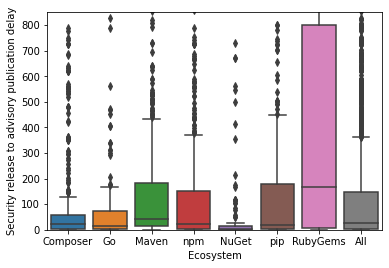

In [220]:
ax = sns.boxplot(y='rtp_delay', x='ecosystem', data = temp, order =['Composer','Go','Maven','npm','NuGet','pip','RubyGems', 'All'])
ax.set(ylim=(0,850), xlabel='Ecosystem', ylabel='Security release to advisory publication delay')
plt.savefig('rtp_delay.png',bbox_inches='tight')

In [221]:
cve = df[~df['cve_date'].isna()]
cve['rtp_delay'].median(), len(cve)

(21.0, 1850)

In [222]:
noncve = df[df['cve_date'].isna()]
noncve['rtp_delay'].median()

55.0

In [223]:
mannwhitneyu(cve['rtp_delay'], noncve['rtp_delay'])

MannwhitneyuResult(statistic=464128.0, pvalue=8.438916751847408e-24)

In [224]:
df['release_year'] = df['release_date'].dt.year
df.groupby('release_year')[['rtp_delay']].median()

,rtp_delay
release_year,
2005,855.0
2006,7.0
2008,3493.0
2009,539.5
2010,948.0
2011,528.0
2012,269.0
2013,148.0
2014,170.5


In [225]:
usage.groupby('ecosystem')[['dependent_repos']].median()

,dependent_repos
ecosystem,
Composer,62.0
Go,0.0
Maven,2.0
NuGet,25.0
RubyGems,0.0
npm,6.5
pip,41.0


In [226]:
len(df)

2527